In [1]:
from numpy import array, random, hstack, reshape, ravel
from matplotlib import pyplot as plt
from skimage import color
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score
from PIL import Image
from os import listdir, sep
from sklearn.model_selection import train_test_split
from tqdm import tqdm

## Подготовка данных датасета

In [2]:
def load_data(path, amount_per_category=10e6):
    '''
    На вход функция ожидает получить путь до директории с папками, в каждой такой папке хранятся изображения, соответствующие
    определенной категории. 
    Функция возвращает два списка: 
        - список images, хранящий изображения в формате np.array();
        - список labels, хранящий лейбл класса (число от 0 до 14), соответствующий данному изображению.
    '''
    images, labels = [], []
    categories = listdir(path)
    for i in tqdm(range(len(categories))):
        category_path = path + categories[i] + sep
        counter = 0
        for pic in listdir(category_path):
            image = array(Image.open(category_path + pic), dtype='uint8')
            images.append(image)
            labels.append(i)

            counter += 1
            if counter > amount_per_category:
                break
    
    return images, labels
    
def to_gray(images):
    '''
    Фунцкия-генератор получает на вход список, содержащий массивы, соответствующие цветным изображениям.
    Переводит каждый элемент полученно списка в массив чисел, соответствующий серому изображению.
    '''
    gray_images = []
    for el in images:
        #gray_images.append(color.rgb2gray(el))
        yield color.rgb2gray(el)
    #return gray_images

def get_hog_features(data):
    '''
    Функция получает на вход список, содержащий массивы чисел, соответствующие изображениям.
    Возвращает два списка:
        - hog_images, содержащий HOG изображения для каждой картинки;
        - hog_features, содержащий признаки изображений.
    '''
    hog_images, hog_features = [], []
    #for image in tqdm(to_gray(data)):
    for image in tqdm(to_gray(data)):
        fd,hog_image = hog(image, orientations=8, pixels_per_cell=(16,16), cells_per_block=(4, 4), block_norm= 'L2', visualize=True)
        hog_images.append(hog_image)
        hog_features.append(fd)
    return hog_images, hog_features

Download dataset

In [4]:
train_images, train_labels = load_data(r'.\Vegetable_Images_EDA\train\\', amount_per_category=1e6)
val_images, val_labels = load_data(r'.\Vegetable_Images_EDA\validation\\', amount_per_category=1e6)
test_images, test_labels = load_data(r'.\Vegetable_Images_EDA\test\\', amount_per_category=1e6)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:21<00:00,  1.42s/it]


HOG

In [5]:
train_hog_im, train_hog_ft = get_hog_features(train_images)
val_hog_im, val_hog_ft = get_hog_features(val_images)
test_hog_im, test_hog_ft = get_hog_features(test_images)

14994it [06:05, 41.00it/s]


Shuffle

In [6]:
train_labels = array(train_labels).reshape(len(train_labels), 1)
train_hog_ft = array(train_hog_ft)
train_data = hstack((train_hog_ft, train_labels))
random.shuffle(train_data)
x_train, y_train = train_data[:, :-1], train_data[:, -1:].ravel()

In [21]:
val_labels = array(val_labels).reshape(len(val_labels), 1)
val_hog_ft = array(val_hog_ft)
val_data = hstack((val_hog_ft, val_labels))
random.shuffle(val_data)
x_val, y_val = val_data[:, :-1], val_data[:, -1:].ravel()

In [22]:
test_labels = array(test_labels).reshape(len(test_labels), 1)
test_hog_ft = array(test_hog_ft)
test_data = hstack((test_hog_ft, test_labels))
random.shuffle(test_data)
x_test, y_test = test_data[:, :-1], test_data[:, -1:].ravel()

## Примеры, визуализация

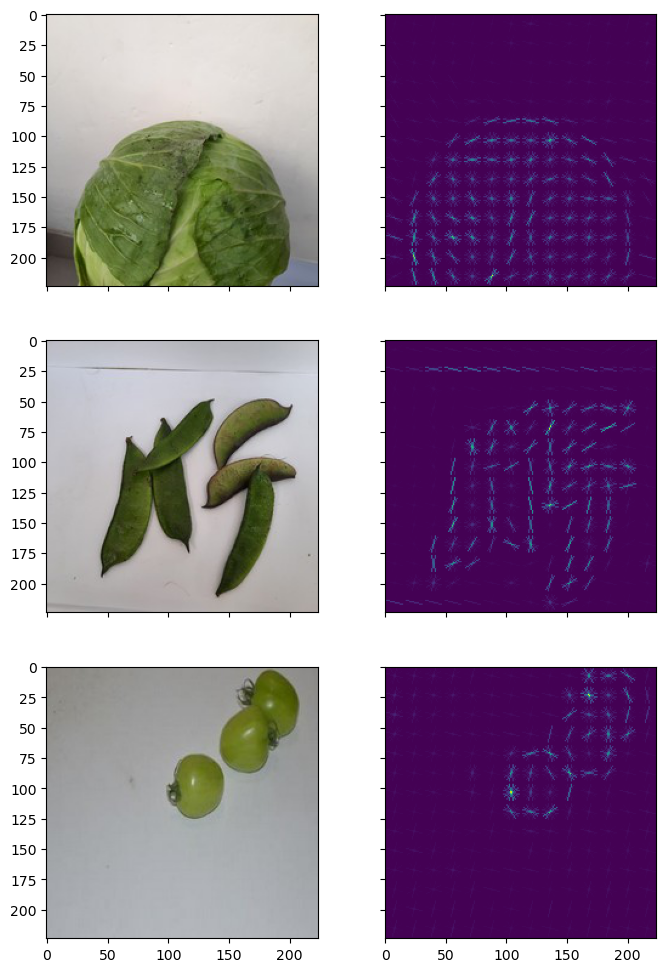

In [25]:
# Исходные изображени и соответствующие им HOG
fig, ax = plt.subplots(3, 2, figsize=(8, 12), sharex=True, sharey=True)
ax[0][0].imshow(train_images[500])
ax[0][1].imshow(train_hog_im[500])
ax[1][0].imshow(val_images[33])
ax[1][1].imshow(val_hog_im[33])
ax[2][0].imshow(test_images[1400])
ax[2][1].imshow(test_hog_im[1400])

## Модель

In [7]:
clf = svm.SVC()

In [8]:
clf.fit(x_train,y_train)

SVC()

In [25]:
import pickle

with open('model.pickle', 'wb') as f:
    pickle.dump(clf, f)

In [33]:
# на случай загрузки готовой модели
with open("model.pickle", "rb") as file:
    deserialized_data = pickle.load(file)

In [25]:
y_pred_val = clf.predict(x_val)

In [27]:
print("Validation Accuracy: "+str(accuracy_score(y_val, y_pred_val)))
print(classification_report(y_val, y_pred_val))

Validation Accuracy: 0.8589059372915276
              precision    recall  f1-score   support

         0.0       0.82      0.79      0.80       200
         1.0       0.88      0.92      0.90       200
         2.0       0.92      0.94      0.93       200
         3.0       0.81      0.83      0.82       200
         4.0       0.89      0.84      0.87       200
         5.0       0.74      0.83      0.78       200
         6.0       0.82      0.93      0.87       200
         7.0       0.90      0.88      0.89       200
         8.0       0.78      0.85      0.82       200
         9.0       0.93      0.88      0.90       200
        10.0       0.93      0.87      0.90       198
        11.0       0.83      0.84      0.84       200
        12.0       0.79      0.70      0.74       200
        13.0       0.95      0.92      0.94       200
        14.0       0.94      0.84      0.89       200

    accuracy                           0.86      2998
   macro avg       0.86      0.86      0

In [26]:
y_pred_test = clf.predict(x_test)

In [28]:
print("Test Accuracy: "+str(accuracy_score(y_test, y_pred_test)))
print(classification_report(y_test, y_pred_test))

Test Accuracy: 0.8659553184394798
              precision    recall  f1-score   support

         0.0       0.81      0.83      0.82       200
         1.0       0.90      0.89      0.89       200
         2.0       0.91      0.95      0.93       200
         3.0       0.81      0.84      0.82       200
         4.0       0.89      0.88      0.88       200
         5.0       0.72      0.90      0.80       200
         6.0       0.86      0.92      0.89       200
         7.0       0.96      0.82      0.88       200
         8.0       0.81      0.79      0.80       200
         9.0       0.93      0.88      0.90       200
        10.0       0.95      0.88      0.91       199
        11.0       0.80      0.89      0.84       200
        12.0       0.84      0.75      0.79       200
        13.0       0.94      0.93      0.93       200
        14.0       0.93      0.84      0.88       200

    accuracy                           0.87      2999
   macro avg       0.87      0.87      0.87   